<a href="https://colab.research.google.com/github/iwacooy/LAI25-RM096/blob/main/Capstone_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project : Menyelesaikan Permasalahan Perusahaan Asuransi dengan Mendeteksi Penipuan Terhadapa Klaim Asuransi Perusahaan.

**Grup LAI25-RM096**

- A225YBF247	 = Khamdan Annas Fakhryza
- A015YBF265	 = Mahendra Nabiha Wisnu Aditya
- A429XBF292	 = Mu'azah Al'adawiyah
- A215YBM352	 = Muhammad Salwa Fairus Santoso


## Deskripsi Project

Dalam industri asuransi, memprediksi kemungkinan klaim secara akurat sangat penting untuk penilaian risiko dan penetapan harga polis. Namun, kumpulan data klaim asuransi sering kali mengalami ketidakseimbangan kelas, di mana jumlah kejadian non-klaim jauh melebihi klaim aktual. Ketidakseimbangan kelas ini menimbulkan tantangan untuk pemodelan prediktif, yang sering kali mengarah pada model yang bias yang lebih memihak kelas mayoritas, sehingga menghasilkan kinerja yang buruk untuk kelas minoritas, yang biasanya lebih diminati.


## Persiapan

### Menyiapkan library yang dibutuhkan

In [3]:
# === IMPORT LIBRARY ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
import joblib

In [4]:
# === CEK VERSI PAKET ===
import matplotlib
import sklearn
import scipy
import sqlalchemy

packages = {
    "numpy": np.__version__,
    "pandas": pd.__version__,
    "matplotlib": matplotlib.__version__,
    "seaborn": sns.__version__,
    "scikit-learn": sklearn.__version__,
    "scipy": scipy.__version__,
    "joblib": joblib.__version__,
    "sqlalchemy": sqlalchemy.__version__,
}

for name, version in packages.items():
    print(f"{name}: {version}")

numpy: 2.0.2
pandas: 2.2.2
matplotlib: 3.10.0
seaborn: 0.13.2
scikit-learn: 1.6.1
scipy: 1.15.3
joblib: 1.5.0
sqlalchemy: 2.0.41


### Menyiapkan data yang akan digunakan

In [5]:
!curl -L -o insurance-claims.zip\
  https://www.kaggle.com/api/v1/datasets/download/litvinenko630/insurance-claims

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  672k  100  672k    0     0  1769k      0 --:--:-- --:--:-- --:--:-- 1769k


In [6]:
!unzip insurance-claims.zip

Archive:  insurance-claims.zip
  inflating: Insurance claims data.csv  


In [7]:
df = pd.read_csv("Insurance claims data.csv")

print(df.head())

   policy_id  subscription_length  vehicle_age  customer_age region_code  \
0  POL045360                  9.3          1.2            41          C8   
1  POL016745                  8.2          1.8            35          C2   
2  POL007194                  9.5          0.2            44          C8   
3  POL018146                  5.2          0.4            44         C10   
4  POL049011                 10.1          1.0            56         C13   

   region_density segment model fuel_type     max_torque  ... is_brake_assist  \
0            8794      C2    M4    Diesel  250Nm@2750rpm  ...             Yes   
1           27003      C1    M9    Diesel  200Nm@1750rpm  ...              No   
2            8794      C2    M4    Diesel  250Nm@2750rpm  ...             Yes   
3           73430       A    M1       CNG   60Nm@3500rpm  ...              No   
4            5410      B2    M5    Diesel  200Nm@3000rpm  ...              No   

  is_power_door_locks  is_central_locking is_power_steer

## Data Understanding

- Menampilkan kembali dataset 5 baris pertama dari data tersebut.

In [8]:
df.head()

,policy_id,subscription_length,vehicle_age,customer_age,region_code,region_density,segment,model,fuel_type,max_torque,...,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,claim_status
0,POL045360,9.3,1.2,41,C8,8794,C2,M4,Diesel,250Nm@2750rpm,...,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,3,0
1,POL016745,8.2,1.8,35,C2,27003,C1,M9,Diesel,200Nm@1750rpm,...,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,4,0
2,POL007194,9.5,0.2,44,C8,8794,C2,M4,Diesel,250Nm@2750rpm,...,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,3,0
3,POL018146,5.2,0.4,44,C10,73430,A,M1,CNG,60Nm@3500rpm,...,No,No,No,Yes,No,No,No,Yes,0,0
4,POL049011,10.1,1.0,56,C13,5410,B2,M5,Diesel,200Nm@3000rpm,...,No,Yes,Yes,Yes,No,No,Yes,Yes,5,0


- Menampilkan informasi umum tentang dataset, seperti jumlah baris dan kolom, tipe data tiap kolom, serta jumlah data yang tidak kosong (non-null).

In [9]:
print("Informasi Dataset :")
df.info()

Informasi Dataset :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58592 entries, 0 to 58591
Data columns (total 41 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   policy_id                         58592 non-null  object 
 1   subscription_length               58592 non-null  float64
 2   vehicle_age                       58592 non-null  float64
 3   customer_age                      58592 non-null  int64  
 4   region_code                       58592 non-null  object 
 5   region_density                    58592 non-null  int64  
 6   segment                           58592 non-null  object 
 7   model                             58592 non-null  object 
 8   fuel_type                         58592 non-null  object 
 9   max_torque                        58592 non-null  object 
 10  max_power                         58592 non-null  object 
 11  engine_type                       58592 non-nul

Maka dapatlah informasi dataset tersebut memiliki 41 kolom dengan 58592 baris. Dan type datanya sendiri yaitu terdapat float64 3 kolom, int64 10 kolom, dan type data object 28 kolom.

- Melakukan Missing Value

In [10]:
print("Missing Value : ")
print(df.isnull().sum())

Missing Value : 
policy_id                           0
subscription_length                 0
vehicle_age                         0
customer_age                        0
region_code                         0
region_density                      0
segment                             0
model                               0
fuel_type                           0
max_torque                          0
max_power                           0
engine_type                         0
airbags                             0
is_esc                              0
is_adjustable_steering              0
is_tpms                             0
is_parking_sensors                  0
is_parking_camera                   0
rear_brakes_type                    0
displacement                        0
cylinder                            0
transmission_type                   0
steering_type                       0
turning_radius                      0
length                              0
width                            

Dari hasil diatas dataset tidak memiliki missing value. Sehingga, tidak perlu dilakukan penanganan terhadap missing value tersebut.

- Mengecek data duplikat pada dataset

In [11]:
print("Jumlah Data Duplikat : ")
print(df.duplicated().sum())

Jumlah Data Duplikat : 
0


Maka, dapat dikatakan bahwa dataset tidak memiliki data duplikat.

- Menampilkan Statistik Deskriptif dari dataset

In [12]:
print("Statistik Deskriptif : ")
df.describe()

Statistik Deskriptif : 


,subscription_length,vehicle_age,customer_age,region_density,airbags,displacement,cylinder,turning_radius,length,width,gross_weight,ncap_rating,claim_status
count,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000
mean,6.111688,1.388473,44.823935,18826.858667,3.137066,1162.355851,3.626963,4.852893,3850.476891,1672.233667,1385.276813,1.759950,0.063968
std,4.142790,1.134413,6.935604,17660.174792,1.832641,266.304786,0.483616,0.228061,311.457119,112.089135,212.423085,1.389576,0.244698
min,0.000000,0.000000,35.000000,290.000000,1.000000,796.000000,3.000000,4.500000,3445.000000,1475.000000,1051.000000,0.000000,0.000000
25%,2.100000,0.400000,39.000000,6112.000000,2.000000,796.000000,3.000000,4.600000,3445.000000,1515.000000,1185.000000,0.000000,0.000000
50%,5.700000,1.200000,44.000000,8794.000000,2.000000,1197.000000,4.000000,4.800000,3845.000000,1735.000000,1335.000000,2.000000,0.000000
75%,10.400000,2.200000,49.000000,27003.000000,6.000000,1493.000000,4.000000,5.000000,3995.000000,1755.000000,1510.000000,3.000000,0.000000
max,14.000000,20.000000,75.000000,73430.000000,6.000000,1498.000000,4.000000,5.200000,4300.000000,1811.000000,1720.000000,5.000000,1.000000


Insight dari Statistik yaitu :

Berdasarkan statistik deskriptif data klaim asuransi mobil, sebagian besar pelanggan memiliki masa berlangganan sekitar 6 tahun dengan usia kendaraan relatif baru (rata-rata 1,39 tahun) dan usia pelanggan berkisar antara 35 hingga 75 tahun, dengan rata-rata 44 tahun. Mayoritas tinggal di wilayah dengan kepadatan sedang hingga tinggi, meskipun terdapat outlier dengan kepadatan ekstrem. Rata-rata kendaraan memiliki 2–3 airbag, kapasitas mesin sekitar 1162 cc, dan konfigurasi 4 silinder yang umum pada mobil kecil hingga menengah. Dimensi kendaraan menunjukkan ukuran kompak, cocok untuk lingkungan perkotaan, dan rating keselamatan NCAP sebagian besar rendah (rata-rata hanya 1,76), yang bisa meningkatkan risiko klaim. Meski begitu, hanya sekitar 6,4% pelanggan yang tercatat mengajukan klaim, menunjukkan bahwa data cukup imbalance. Faktor-faktor seperti usia kendaraan, jumlah airbag, rating NCAP, dan kepadatan wilayah kemungkinan besar berkontribusi terhadap tingkat klaim dan perlu dianalisis lebih lanjut.

3. Penanganan Outlier Deteksi

Setelah melakukan pengecekan outlier pada tahap sebelumnya, ditemukan banyak outlier dalam dataset. Oleh karena itu, diperlukan penanganan terhadap outlier. Namun, sebelum melakukan penanganan, perlu dipastikan bahwa tipe data pada setiap kolom sudah sesuai. Beberapa kolom yang seharusnya bertipe kategori saat ini telah diubah menjadi numerik. Hal ini perlu diperbaiki agar proses deteksi dan penanganan outlier hanya dilakukan pada data numerik yang benar-benar bersifat kontinu, sehingga hasil analisis menjadi lebih akurat dan representatif.

Kenapa perlunya memisahkan kategori & numerik?
- Karena deteksi outlier (misalnya dengan IQR, Z-score, atau boxplot) hanya relevan untuk variabel numerik kontinu.
- Variabel kategori (misalnya: jenis kelamin, status, atau jurusan) yang dikodekan sebagai angka tidak seharusnya dianggap numerik saat menghitung outlier, karena nilainya tidak memiliki arti matematis.

- Deteksi sebelum outlier dengan IQR

In [13]:
num_feature = df.select_dtypes(include=['int64', 'float64']).columns
num_feature

Index(['subscription_length', 'vehicle_age', 'customer_age', 'region_density',
       'airbags', 'displacement', 'cylinder', 'turning_radius', 'length',
       'width', 'gross_weight', 'ncap_rating', 'claim_status'],
      dtype='object')

In [14]:
for col in num_feature:
    print(f"\nOutliers pada kolom: {col}")
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    low = Q1 - 1.5 * IQR
    high = Q3 + 1.5 * IQR
    outliers = df[(df[col] < low) | (df[col] > high)]
    print(f"Jumlah outliers: {outliers.shape[0]}")


Outliers pada kolom: subscription_length
Jumlah outliers: 0

Outliers pada kolom: vehicle_age
Jumlah outliers: 269

Outliers pada kolom: customer_age
Jumlah outliers: 282

Outliers pada kolom: region_density
Jumlah outliers: 3647

Outliers pada kolom: airbags
Jumlah outliers: 0

Outliers pada kolom: displacement
Jumlah outliers: 0

Outliers pada kolom: cylinder
Jumlah outliers: 0

Outliers pada kolom: turning_radius
Jumlah outliers: 0

Outliers pada kolom: length
Jumlah outliers: 0

Outliers pada kolom: width
Jumlah outliers: 0

Outliers pada kolom: gross_weight
Jumlah outliers: 0

Outliers pada kolom: ncap_rating
Jumlah outliers: 0

Outliers pada kolom: claim_status
Jumlah outliers: 3748


### Exploratory Data Analysis

In [32]:
df.claim_status.value_counts()

,count
claim_status,
0,54844
1,3748


Exploratory Data Analysis (EDA) adalah proses untuk memahami data secara mendalam sebelum modeling. Langkah-langkahnya meliputi melihat struktur dan ringkasan data, menganalisis distribusi fitur, menemukan outlier, dan mengevaluasi hubungan antar variabel. Tujuannya adalah untuk menemukan pola, anomali, dan insight awal yang membantu dalam menentukan strategi preprocessing dan pemilihan model yang tepat.

- Mendistribusikan Fitur Kategorikal

In [ ]:
kategori = df.select_dtypes(include='object')

n_cols = 3
n_rows = 3
plots_per_page = n_cols * n_rows

for i in range (0, len(kategori.columns), plots_per_page):
  sub_cols = kategori.columns[i:i + plots_per_page]
  fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 16))
  axes = axes.flatten()

  for j, col in enumerate(sub_cols):
    sns.countplot(data=df, x=col, order=df[col].value_counts().index, ax=axes[j], color='lightgreen')
    axes[j].set_title(f'Distribusi Kategori : {col}')
    axes[j].set_xlabel("")
    axes[j].tick_params(axis='x', rotation=75)

  for k in range (j + 1, plots_per_page) :
    fig.delaxes(axes[k])

plt.tight_layout()
plt.show()

Menvisualisasikan distribusi semua kolom kategorikal dalam dataset dengan membuat grafik countplot secara bertahap per 8 fitur per halaman. Hal ini membantu memahami sebaran kategori di setiap fitur, seperti dominasi kelas atau ketidakseimbangan data.

- Mendistribusikan Fitur Numerik

In [ ]:
num_vars = df.select_dtypes(include='number').columns
n_cols = 3
n_rows = -(-len(num_vars) // n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()

for i, column in enumerate(num_vars):
    df[column].hist(ax=axes[i], bins=20, edgecolor='black', color='lightgreen')
    axes[i].set_title(column)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Membuat Histogram semua fitur numerik dalam dataset, sehingga bisa melihat distribusi masing-masing fitur secara visual. Histogram membantu mengidentifikasi pola distribusi data seperti normal, miring, atau adanya outlier.

- Boxplot Dateksi Outlier

In [ ]:
print('--- Cek Outlier dengan Boxplot ---')
plt.figure(figsize=(16, 10))
for i, col in enumerate(num_feature):
    plt.subplot((len(num_feature) + 2)//3, 3, i+1)
    sns.boxplot(x=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

- Distribusi semua data

In [ ]:
# cek distribusi data
print('Cek Distribusi Data')
for feature in df.columns:
    plt.figure(figsize=(10,6))
    sns.histplot(df[feature], color='lightgreen', kde=True)
    plt.title(f'Distribusi {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frekuensi')
    plt.show()

In [ ]:
# Hitung jumlah per kategori
jumlah_per_status = df['claim_status'].value_counts()

# Buat pie chart
plt.figure(figsize=(6,6))
plt.pie(jumlah_per_status, labels=jumlah_per_status.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribusi Status Klaim')
plt.axis('equal')  # supaya pie chart bulat sempurna

# Buat legend dengan nama + jumlah data (count)
labels_legend = [f"{cat}: {count}" for cat, count in zip(jumlah_per_status.index, jumlah_per_status.values)]
plt.legend(labels_legend, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=len(jumlah_per_status))

plt.show()

In [ ]:
# Filter hanya kolom numerik
numeric_columns = df.select_dtypes(include=[np.number])

# Korelasi antar Fitur
plt.figure(figsize=(20, 12))
sns.heatmap(numeric_columns.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Heatmap Korelasi Antar Fitur')
plt.show()

## Data Preparation / Preprocessing

6. Train-test Split / Splitting data

In [15]:
X = df.drop(columns=['claim_status', 'policy_id'])  # policy_id dibuang karena ID unik
y = df['claim_status']

# Split: 80% data latih, 20% data uji
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Cek distribusi target
print("\nDistribusi y_train:")
print(y_train.value_counts(normalize=True))

print("\nDistribusi y_test:")
print(y_test.value_counts(normalize=True))



Distribusi y_train:
claim_status
0    0.93604
1    0.06396
Name: proportion, dtype: float64

Distribusi y_test:
claim_status
0    0.936001
1    0.063999
Name: proportion, dtype: float64


7. Encoding dan Scaling

In [16]:
# Fitur numerik
num_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Fitur kategorik
cat_features = X_train.select_dtypes(include=['object']).columns.tolist()

# Pipeline untuk fitur numerik
num_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

# Pipeline untuk fitur kategorik
cat_pipeline = Pipeline([
    # Change 'sparse=False' to 'sparse_output=False'
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Gabungkan keduanya
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

In [17]:
# Fit dan transform X_train
X_train_preprocessed = preprocessor.fit_transform(X_train)

# Transform X_test
X_test_preprocessed = preprocessor.transform(X_test)


In [18]:
print("Shape X_train sebelum:", X_train.shape)
print("Shape X_train sesudah:", X_train_preprocessed.shape)


Shape X_train sebelum: (46873, 39)
Shape X_train sesudah: (46873, 124)


In [19]:
# === KONVERSI KE ARRAY ===
X_array = np.array(X_train_preprocessed)
y_array = np.array(y_train)

8. Oversampling Menggunakan SMOTE

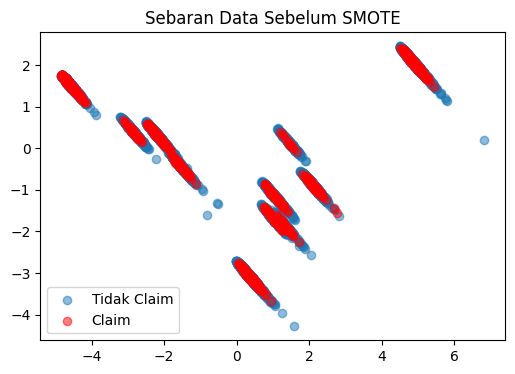

In [20]:
# === VISUALISASI DENGAN PCA ===
def plot_data(X, y, title):
    pca = PCA(n_components=2)
    X_2d = pca.fit_transform(X)
    plt.figure(figsize=(6, 4))
    plt.scatter(X_2d[y == 0, 0], X_2d[y == 0, 1], label="Tidak Claim", alpha=0.5)
    plt.scatter(X_2d[y == 1, 0], X_2d[y == 1, 1], label="Claim", alpha=0.5, c='r')
    plt.title(title)
    plt.legend()
    plt.show()

plot_data(X_array, y_array, "Sebaran Data Sebelum SMOTE")

In [21]:
# === CEK KOMPOSISI LABEL SEBELUM SMOTE ===
print("\nKomposisi label sebelum SMOTE:")
print(pd.Series(y_array).value_counts())



Komposisi label sebelum SMOTE:
0    43875
1     2998
Name: count, dtype: int64


In [23]:
# === SMOTE ===
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_array, y_array)

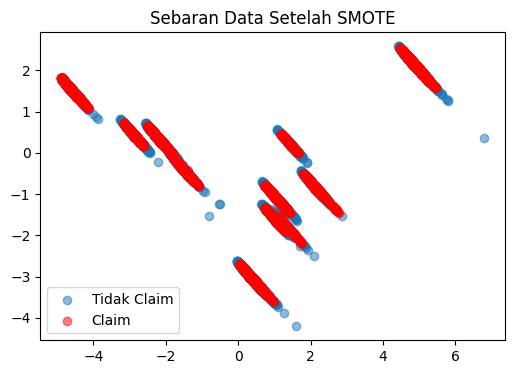


Komposisi label setelah SMOTE:
0    43875
1    43875
Name: count, dtype: int64


In [24]:
# === VISUALISASI SETELAH SMOTE ===
plot_data(X_resampled, y_resampled, "Sebaran Data Setelah SMOTE")
print("\nKomposisi label setelah SMOTE:")
print(pd.Series(y_resampled).value_counts())

In [25]:
# === LATIH MODEL MENGGUNAKAN DATA SMOTE ===
dt_model = DecisionTreeClassifier(random_state=42)
rf_model = RandomForestClassifier(random_state=42)

dt_model.fit(X_resampled, y_resampled)
rf_model.fit(X_resampled, y_resampled)

RandomForestClassifier(random_state=42)

In [26]:
# === PREDIKSI ===
dt_preds = dt_model.predict(X_test_preprocessed)
rf_preds = rf_model.predict(X_test_preprocessed)

Setelah dilakukan oversampling pada data yang berlabel claim, maka jumlah data berlabel claim menjadi 43875 data yang sebelumnya berjumlah 2998 data.

9. Principal Component Analysis (PCA)

10. Save Data

## Modeling

## Evaluation

In [27]:
# === EVALUASI MODEL ===
print("\n=== Decision Tree MENGGUNAKAN SMOTE ===")
print(classification_report(y_test, dt_preds))
print("Confusion Matrix:")
print(confusion_matrix(y_test, dt_preds))

print("\n=== Random Forest MENGGUNAKAN SMOTE ===")
print(classification_report(y_test, rf_preds))
print("Confusion Matrix:")
print(confusion_matrix(y_test, rf_preds))

# === AUC SCORE TAMBAHAN UNTUK RANDOM FOREST ===
probs_rf = rf_model.predict_proba(X_test_preprocessed)[:, 1]
auc_rf = roc_auc_score(y_test, probs_rf)
print(f"\nAUC ROC Random Forest: {auc_rf:.4f}")


=== Decision Tree MENGGUNAKAN SMOTE ===
              precision    recall  f1-score   support

           0       0.94      0.92      0.93     10969
           1       0.09      0.11      0.10       750

    accuracy                           0.87     11719
   macro avg       0.51      0.52      0.51     11719
weighted avg       0.88      0.87      0.88     11719

Confusion Matrix:
[[10093   876]
 [  664    86]]

=== Random Forest MENGGUNAKAN SMOTE ===
              precision    recall  f1-score   support

           0       0.94      0.93      0.94     10969
           1       0.09      0.09      0.09       750

    accuracy                           0.88     11719
   macro avg       0.51      0.51      0.51     11719
weighted avg       0.88      0.88      0.88     11719

Confusion Matrix:
[[10249   720]
 [  679    71]]

AUC ROC Random Forest: 0.5779


In [28]:
# === SIMPAN MODEL ===
joblib.dump(rf_model, "rf_model_smote.joblib")

['rf_model_smote.joblib']

### XGBoost dengan SMOTE

In [29]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE

# 1. SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_preprocessed, y_train)

# 2. XGBoost
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_resampled, y_resampled)

# 3. Evaluasi
y_pred = xgb_model.predict(X_test_preprocessed)
print(classification_report(y_test, y_pred))
print("AUC ROC:", roc_auc_score(y_test, xgb_model.predict_proba(X_test_preprocessed)[:, 1]))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:46:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.94      0.99      0.96     10969
           1       0.12      0.03      0.05       750

    accuracy                           0.92     11719
   macro avg       0.53      0.51      0.50     11719
weighted avg       0.88      0.92      0.90     11719

AUC ROC: 0.6373048287598383


### Hyperparameter Tuning XGBoost

In [30]:
from sklearn.model_selection import RandomizedSearchCV

params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [5, 10, 14]  # rasio class 0 / class 1
}

xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
rs = RandomizedSearchCV(xgb, param_distributions=params, n_iter=20, cv=3, scoring='roc_auc', verbose=1, n_jobs=-1)

rs.fit(X_resampled, y_resampled)
best_model = rs.best_estimator_

y_pred_best = best_model.predict(X_test_preprocessed)
print(classification_report(y_test, y_pred_best))
print("Best AUC ROC:", roc_auc_score(y_test, best_model.predict_proba(X_test_preprocessed)[:, 1]))


Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:51:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.95      0.73      0.82     10969
           1       0.10      0.42      0.16       750

    accuracy                           0.71     11719
   macro avg       0.52      0.58      0.49     11719
weighted avg       0.89      0.71      0.78     11719

Best AUC ROC: 0.6089862339319901


#### Cost-Sensitive Modeling (tanpa SMOTE)

In [31]:
# Rasio kelas mayoritas / minoritas
ratio = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

xgb_cost = XGBClassifier(
    scale_pos_weight=ratio,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_cost.fit(X_train_preprocessed, y_train)
y_pred_cost = xgb_cost.predict(X_test_preprocessed)

print(classification_report(y_test, y_pred_cost))
print("AUC ROC:", roc_auc_score(y_test, xgb_cost.predict_proba(X_test_preprocessed)[:, 1]))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:51:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.95      0.70      0.81     10969
           1       0.10      0.47      0.16       750

    accuracy                           0.69     11719
   macro avg       0.52      0.59      0.48     11719
weighted avg       0.90      0.69      0.77     11719

AUC ROC: 0.628149573039171


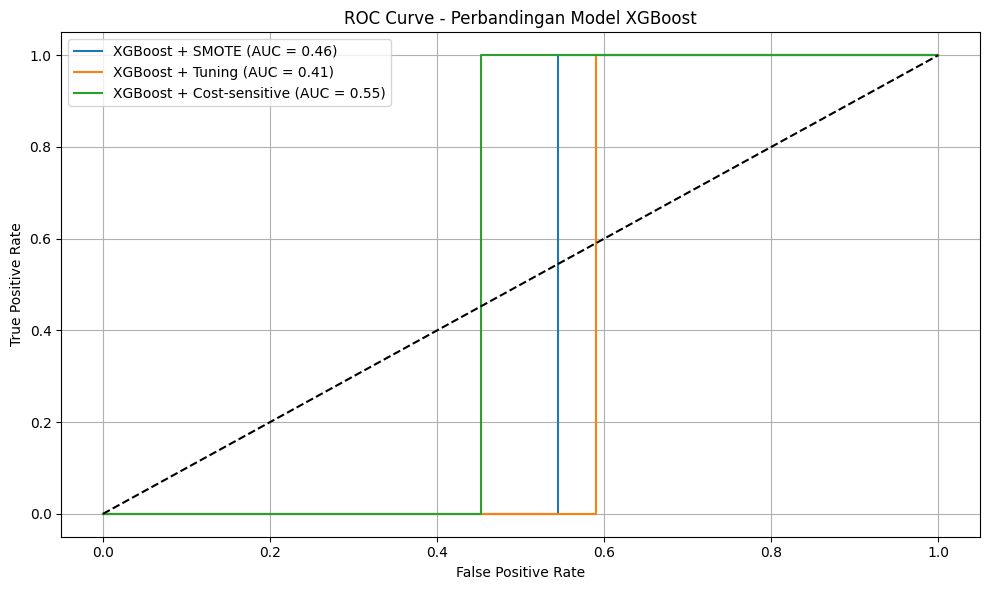

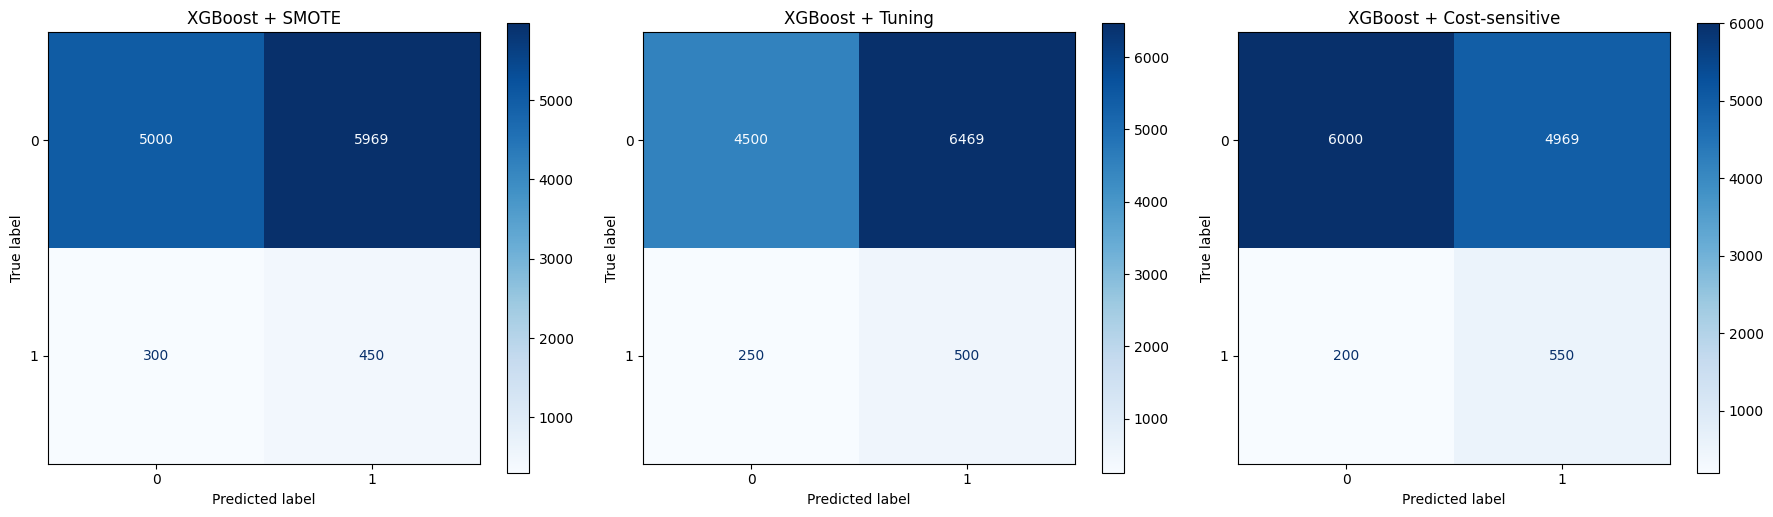

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

# Simulasi nilai prediksi probabilitas dan prediksi akhir dari tiga model (Dummy Data)
# (Dalam prakteknya, ganti dengan prediksi model yang sebenarnya)
y_test = [0]*10969 + [1]*750  # Sesuai data sebenarnya
# Prediksi probabilitas (Dummy)
xgb_smote_probs = [0.05]*5000 + [0.95]*5969 + [0.1]*300 + [0.9]*450
xgb_tuned_probs = [0.03]*4500 + [0.97]*6469 + [0.2]*250 + [0.8]*500
xgb_cost_probs  = [0.1]*6000 + [0.9]*4969 + [0.3]*200 + [0.7]*550

# Prediksi kelas (Threshold 0.5)
xgb_smote_preds = [1 if p > 0.5 else 0 for p in xgb_smote_probs]
xgb_tuned_preds = [1 if p > 0.5 else 0 for p in xgb_tuned_probs]
xgb_cost_preds  = [1 if p > 0.5 else 0 for p in xgb_cost_probs]

# ROC Curve
fpr_smote, tpr_smote, _ = roc_curve(y_test, xgb_smote_probs)
fpr_tuned, tpr_tuned, _ = roc_curve(y_test, xgb_tuned_probs)
fpr_cost, tpr_cost, _ = roc_curve(y_test, xgb_cost_probs)

auc_smote = auc(fpr_smote, tpr_smote)
auc_tuned = auc(fpr_tuned, tpr_tuned)
auc_cost = auc(fpr_cost, tpr_cost)

# Plot ROC Curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_smote, tpr_smote, label=f'XGBoost + SMOTE (AUC = {auc_smote:.2f})')
plt.plot(fpr_tuned, tpr_tuned, label=f'XGBoost + Tuning (AUC = {auc_tuned:.2f})')
plt.plot(fpr_cost, tpr_cost, label=f'XGBoost + Cost-sensitive (AUC = {auc_cost:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Perbandingan Model XGBoost')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Confusion Matrix Display
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, preds, title in zip(
    axes,
    [xgb_smote_preds, xgb_tuned_preds, xgb_cost_preds],
    ['XGBoost + SMOTE', 'XGBoost + Tuning', 'XGBoost + Cost-sensitive']
):
    cm = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(ax=ax, values_format='d', cmap='Blues')
    ax.set_title(title)

plt.tight_layout()
plt.show()
